<a href="https://colab.research.google.com/github/thedeveloper2104/NASH_2023_bro_code/blob/main/random_forest_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import sklearn.metrics as metrics

In [ ]:
## Load data using pandas read_csv method
df = pd.read_csv('/content/sample_data/powerconsumption.csv')

#Setting index to Datetime
df = df.set_index('Datetime')
df.index = pd.to_datetime(df.index)

#Visualizing dataset first 5 records
df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3
Datetime,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964


In [ ]:
#Checking % of Null values within dataset
missed = pd.DataFrame()

missed['column'] = df.columns

missed['percent'] = [round(100* df[col].isnull().sum() / len(df), 2) for col in df.columns]

missed = missed.sort_values('percent',ascending=False)
print(missed)

                   column  percent
0             Temperature      0.0
1                Humidity      0.0
2               WindSpeed      0.0
3     GeneralDiffuseFlows      0.0
4            DiffuseFlows      0.0
5  PowerConsumption_Zone1      0.0
6  PowerConsumption_Zone2      0.0
7  PowerConsumption_Zone3      0.0


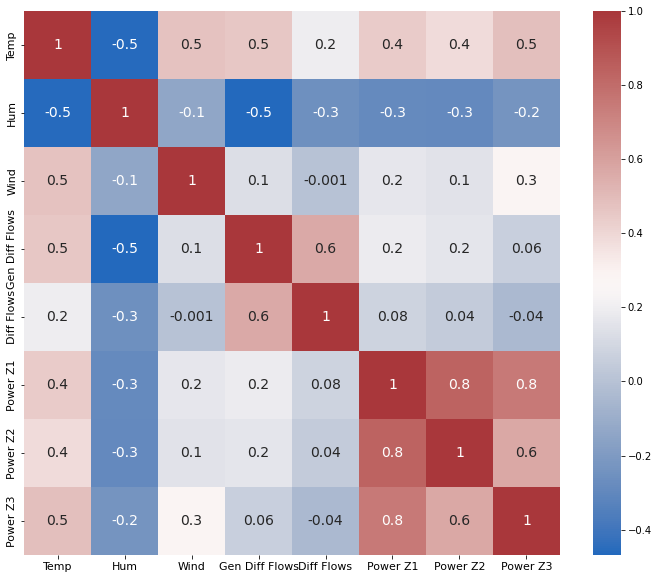

In [ ]:
##Correlation Matrix

#Renaming axis labels
axis_labels = ['Temp', 'Hum', 'Wind', 'Gen Diff Flows', 'Diff Flows', 'Power Z1', 'Power Z2', 'Power Z3']

#Setting dimensions and generating heatmap with Seaborn
fig, ax = plt.subplots(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, ax=ax, cmap = 'vlag', fmt='.1g', annot_kws={
                'fontsize': 14,
                'fontweight': 'regular',
            }, xticklabels= axis_labels, yticklabels=axis_labels)

#Setting Fontsize for labels
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

#Generating plot
plt.show()

In [ ]:
## Feature Engineering extracts the hour, day of the week, quarter, month etc. from the datetime index

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week
    return df

df = create_features(df)

In [ ]:
#Calculating 10-day, 15-day and 30-day Simple Moving Average

df['SMA10'] = df['PowerConsumption_Zone1'].rolling(10).mean()
df['SMA15'] = df['PowerConsumption_Zone1'].rolling(15).mean()
df['SMA30'] = df['PowerConsumption_Zone1'].rolling(30).mean()

df.head()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30
Datetime,,,,,,,,,,,,,,,,,,,
2017-01-01 00:00:00,6.559,73.8,0.083,0.051,0.119,34055.69620,16128.87538,20240.96386,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:10:00,6.414,74.5,0.083,0.070,0.085,29814.68354,19375.07599,20131.08434,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:20:00,6.313,74.5,0.080,0.062,0.100,29128.10127,19006.68693,19668.43373,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:30:00,6.121,75.0,0.083,0.091,0.096,28228.86076,18361.09422,18899.27711,0,6,1,1,2017,1,1,52,NaN,NaN,NaN
2017-01-01 00:40:00,5.921,75.7,0.081,0.048,0.085,27335.69620,17872.34043,18442.40964,0,6,1,1,2017,1,1,52,NaN,NaN,NaN


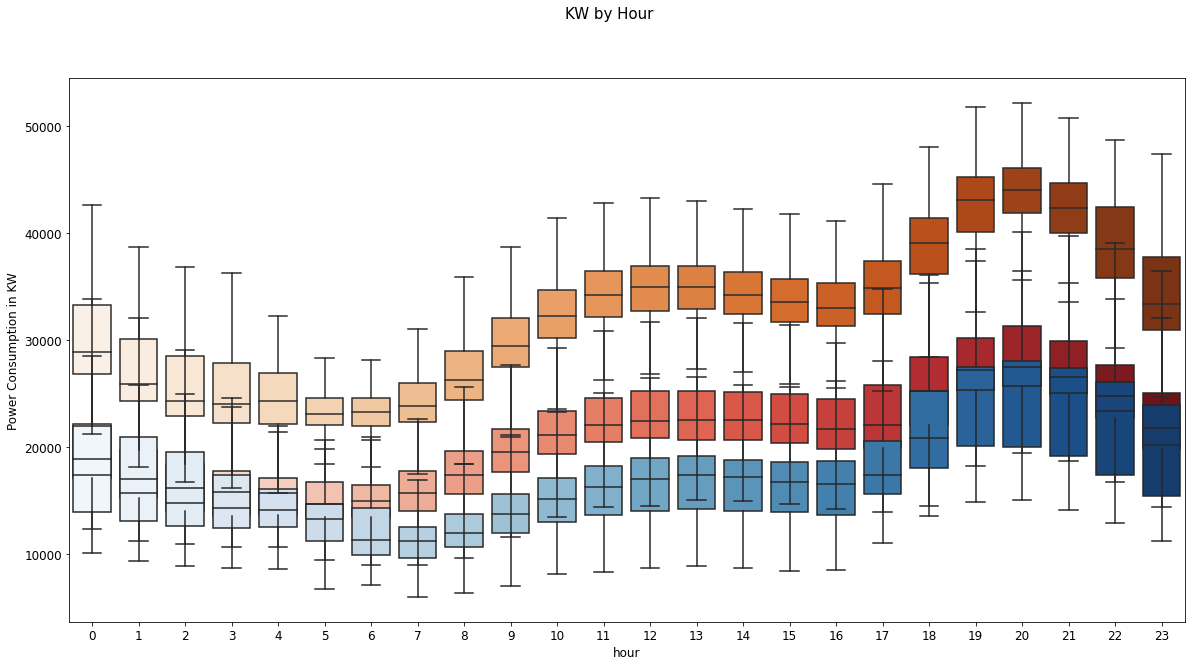

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

zone1 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone1', palette = 'Oranges', showfliers=False)
zone2 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone2', palette = 'Reds', showfliers=False)
zone3 = sns.boxplot(data=df, x='hour', y='PowerConsumption_Zone3', palette = 'Blues', showfliers=False)

plt.suptitle('KW by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

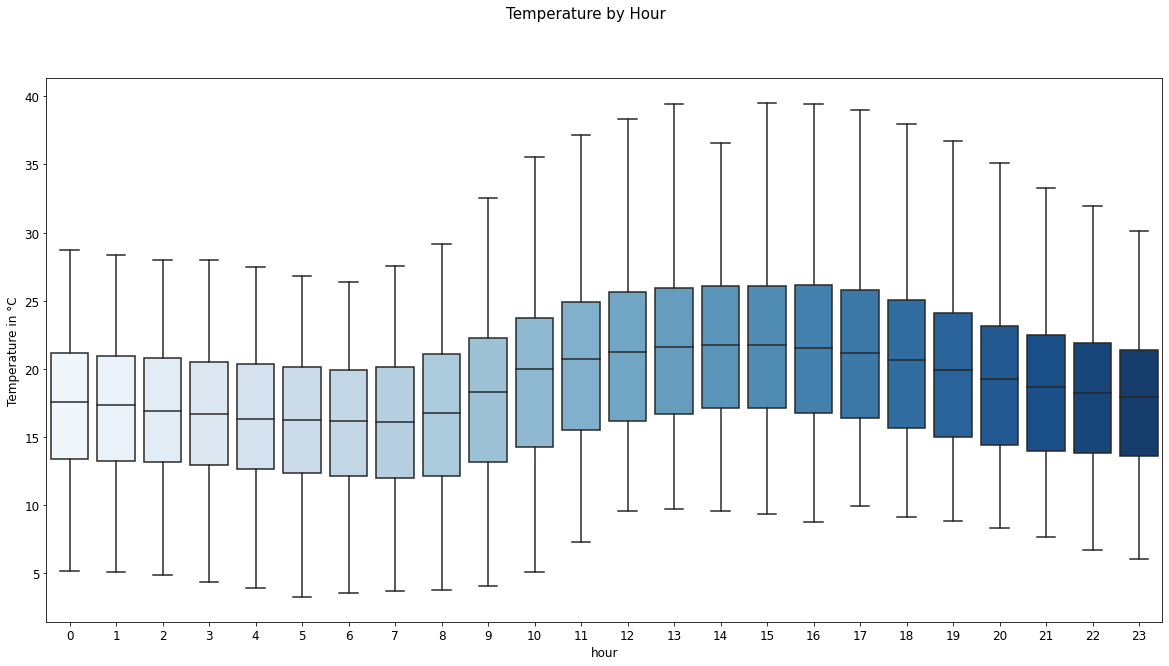

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Temperature', palette = 'Blues', showfliers=False)

plt.suptitle('Temperature by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Temperature in °C', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

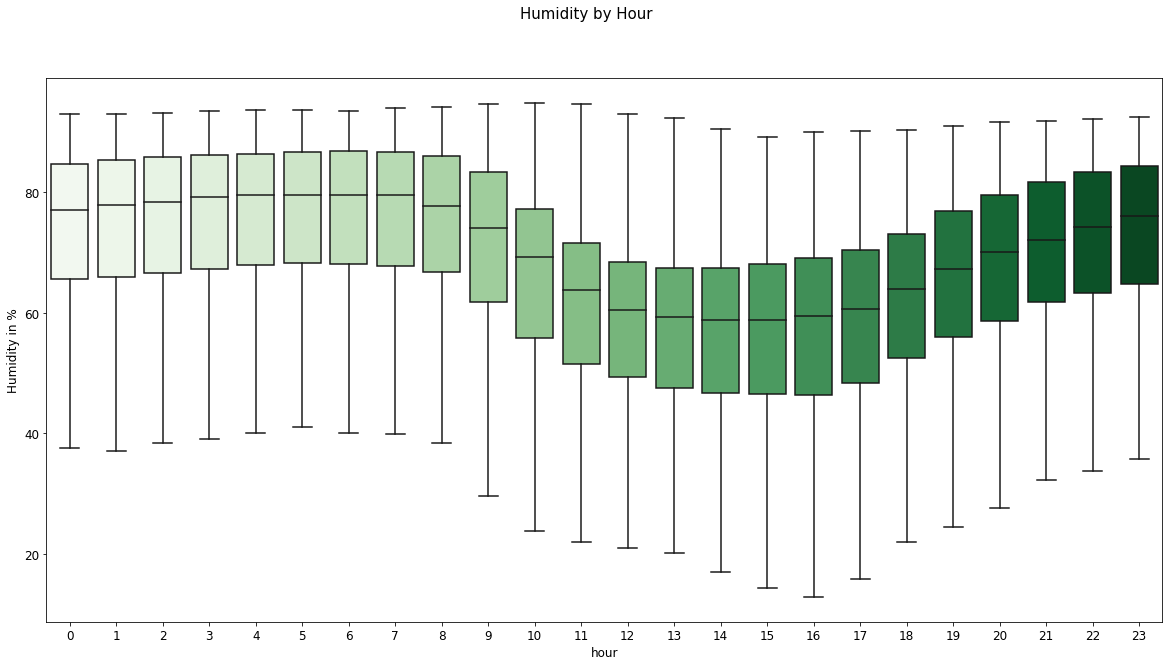

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))

sns.boxplot(data=df, x='hour', y='Humidity', palette = 'Greens', showfliers=False)

plt.suptitle('Humidity by Hour', fontsize=15)
plt.xlabel('hour', fontsize=12)
plt.ylabel('Humidity in %', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

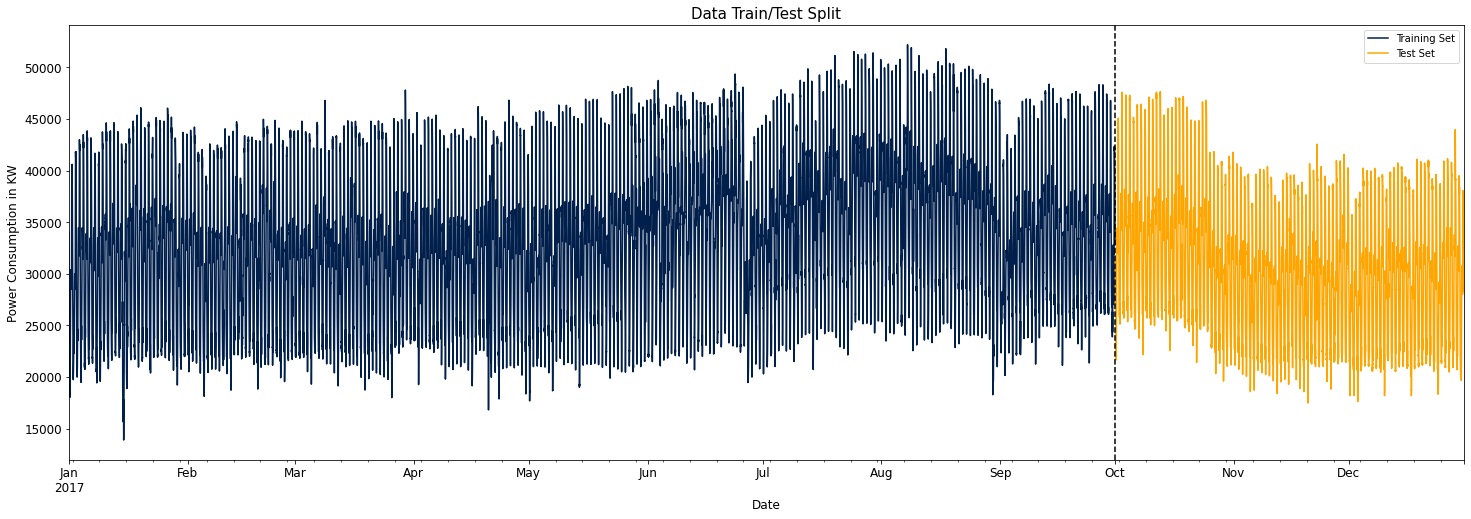

In [ ]:
#Train and Test Split
zone_1 = df['PowerConsumption_Zone1']

train = zone_1.loc[zone_1.index < '10-01-2017']
test = zone_1.loc[zone_1.index >= '10-01-2017']

fig, ax = plt.subplots(figsize=(25, 8))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split', color = "#011f4b")
test.plot(ax=ax, label='Test Set', color="orange")

ax.axvline('10-01-2017', color='black', ls='--')
ax.legend(['Training Set', 'Test Set'])

plt.title('Data Train/Test Split', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

#Generating plot
plt.show()

In [ ]:
## Defining input and target variable

#Training data goes from 1st January until 30th of September, input variables are all the columns in the dataset apart from Zone 1,2,3 consumption
X_train = df.loc[:'10-01-2017',['Humidity', 'Temperature', 'WindSpeed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y_train = df.loc[:'10-01-2017', ['PowerConsumption_Zone1']]

#Testing data goes from 1st January until 30th of September, input variables are all the columns in the dataset apart from Zone 1,2,3 consumption
X_test = df.loc['10-01-2017':,['Humidity', 'Temperature', 'WindSpeed','dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year','SMA10', 'SMA30', 'SMA15']]
y_test = df.loc['10-01-2017':, ['PowerConsumption_Zone1']]

In [ ]:
from sklearn.ensemble import RandomForestRegressor

X_train_without_na = X_train.fillna(0)
y_train_without_na = y_train.fillna(0)

# Create a random forest regression model with 100 trees
model_rf = RandomForestRegressor(n_estimators=100)

# Fit the model to the training data
model_rf.fit(X_train_without_na, y_train_without_na)

# Use the model to make predictions on the testing data
y_pred = model_rf.predict(X_test)

# Calculate the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)

print(f"Mean squared error: {mse}")


<ipython-input-12-dce246b940c5>:11: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model_rf.fit(X_train_without_na, y_train_without_na)


Mean squared error: 3049480.055056019


In [ ]:
y_test['prediction'] = y_pred
df = df.merge(y_test[['prediction']], how='left', left_index=True, right_index=True)

df.tail()

,Temperature,Humidity,WindSpeed,GeneralDiffuseFlows,DiffuseFlows,PowerConsumption_Zone1,PowerConsumption_Zone2,PowerConsumption_Zone3,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,SMA10,SMA15,SMA30,prediction
Datetime,,,,,,,,,,,,,,,,,,,,
2017-12-30 23:10:00,7.010,72.4,0.080,0.040,0.096,31160.45627,26857.31820,14780.31212,23,5,4,12,2017,364,30,52,33634.068441,34403.447401,35936.121673,33704.529520
2017-12-30 23:20:00,6.947,72.6,0.082,0.051,0.093,30430.41825,26124.57809,14428.81152,23,5,4,12,2017,364,30,52,33217.946768,33990.570342,35683.041825,33538.190400
2017-12-30 23:30:00,6.900,72.8,0.086,0.084,0.074,29590.87452,25277.69254,13806.48259,23,5,4,12,2017,364,30,52,32730.038022,33540.380227,35402.382763,32861.174405
2017-12-30 23:40:00,6.758,73.0,0.080,0.066,0.089,28958.17490,24692.23688,13512.60504,23,5,4,12,2017,364,30,52,32133.840303,33082.078579,35107.528517,28190.829342
2017-12-30 23:50:00,6.580,74.1,0.081,0.062,0.111,28349.80989,24055.23167,13345.49820,23,5,4,12,2017,364,30,52,31495.057033,32597.820025,34796.451204,27759.780289


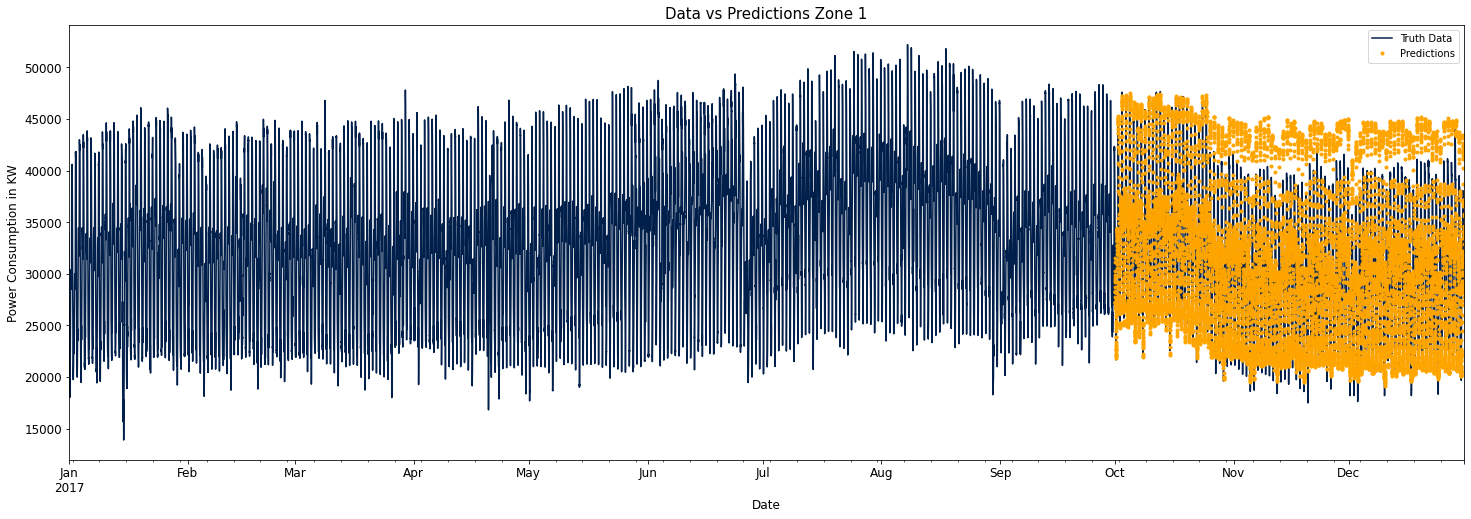

In [ ]:
ax = df[['PowerConsumption_Zone1']].plot(figsize=(25, 8), color = "#011f4b")
y_test['prediction'].plot(ax=ax, style='.', color = "orange")
plt.legend(['Truth Data', 'Predictions'])

plt.title('Data vs Predictions Zone 1', fontsize=15)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [ ]:
df.columns

Index(['Temperature', 'Humidity', 'WindSpeed', 'GeneralDiffuseFlows',
       'DiffuseFlows', 'PowerConsumption_Zone1', 'PowerConsumption_Zone2',
       'PowerConsumption_Zone3', 'hour', 'dayofweek', 'quarter', 'month',
       'year', 'dayofyear', 'dayofmonth', 'weekofyear', 'SMA10', 'SMA15',
       'SMA30', 'prediction'],
      dtype='object')

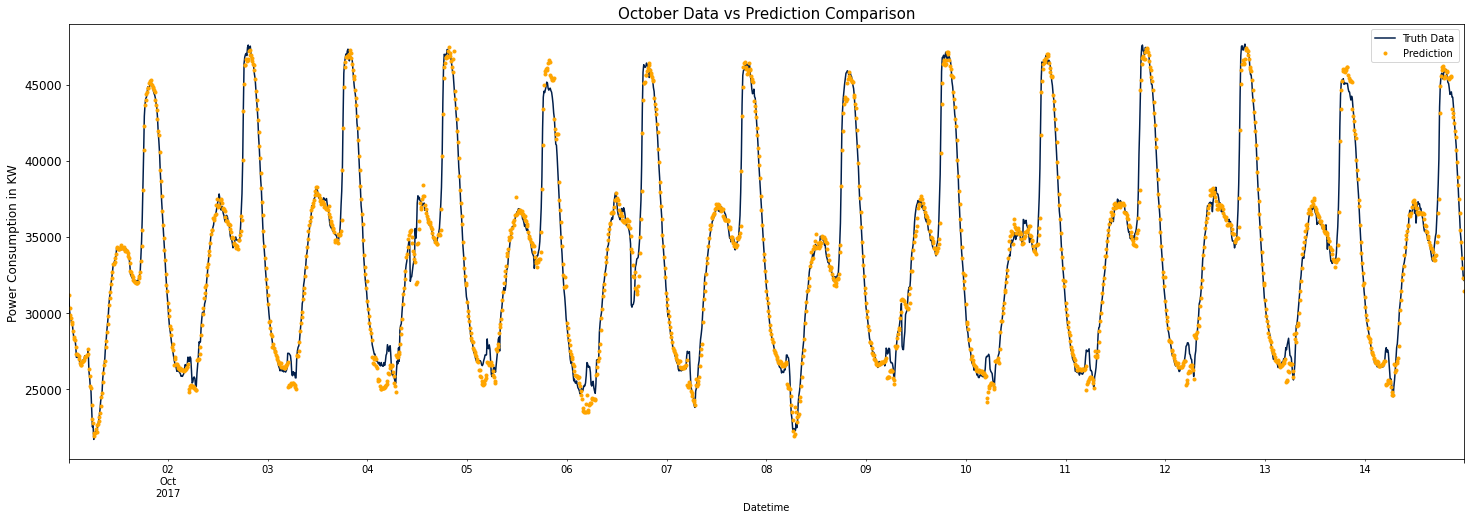

In [ ]:
##Printing October predictions on chart to visually assess accuracy
ax = df.loc[(df.index > '10-01-2017') & (df.index < '10-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='October Data vs Prediction Comparison', color = "#011f4b")
df.loc[(df.index > '10-01-2017') & (df.index < '10-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('October Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

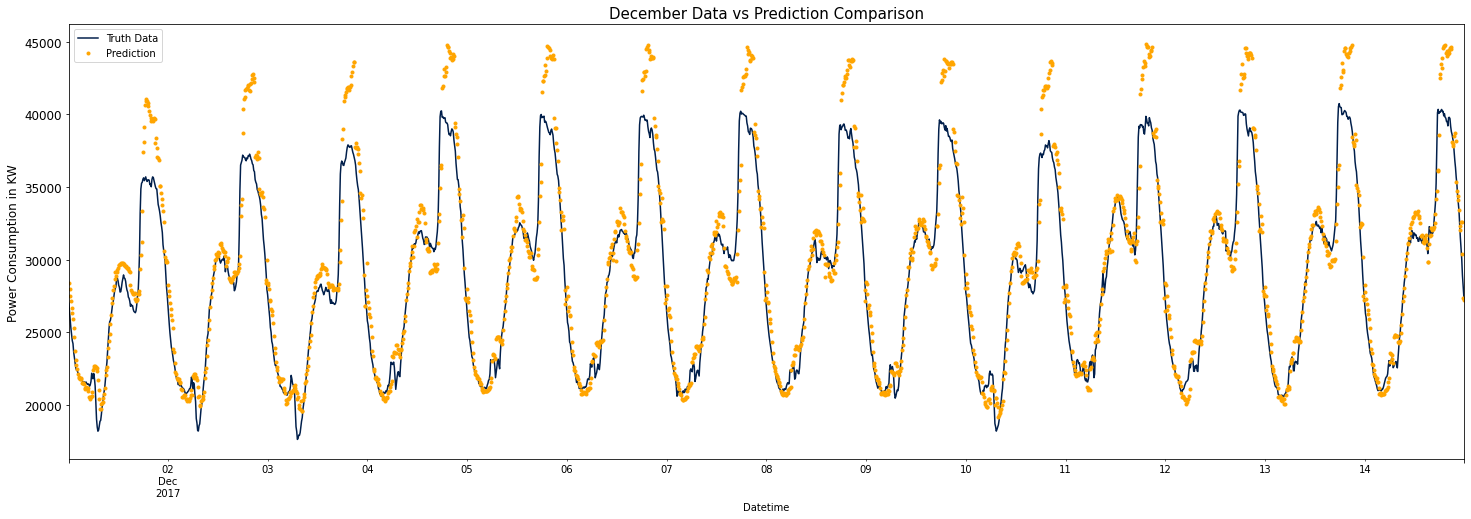

In [ ]:
##Printing December predictions on chart to visually assess accuracy
ax = df.loc[(df.index > '12-01-2017') & (df.index < '12-15-2017')]['PowerConsumption_Zone1'] \
    .plot(figsize=(25, 8), title='December Data vs Prediction Comparison', color = "#011f4b")
df.loc[(df.index > '12-01-2017') & (df.index < '12-15-2017')]['prediction'] \
    .plot(style='.', color = "orange")

plt.title('December Data vs Prediction Comparison', fontsize=15)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Power Consumption in KW', fontsize=12)
plt.legend(['Truth Data','Prediction'])

plt.show()

In [ ]:
##Function to calculate regression metrics, evaluating accuracy
def regression_results(y_true, y_pred):

    # Regression metrics
    explained_variance=metrics.explained_variance_score(y_true, y_pred)
    mean_absolute_error=metrics.mean_absolute_error(y_true, y_pred) 
    mse=metrics.mean_squared_error(y_true, y_pred) 
    mean_squared_log_error=metrics.mean_squared_log_error(y_true, y_pred)
    median_absolute_error=metrics.median_absolute_error(y_true, y_pred)
    r2=metrics.r2_score(y_true, y_pred)
    mape = (1- metrics.mean_absolute_percentage_error(y_true, y_pred))


    print('explained_variance: ', round(explained_variance,4))    
    print('mean_squared_log_error: ', round(mean_squared_log_error,4))
    print('r2: ', round(r2,4))
    print('MAE: ', round(mean_absolute_error,4))
    print('MSE: ', round(mse,4))
    print('RMSE: ', round(np.sqrt(mse),4))
    print('MAPE: ', round(mape,4))

In [ ]:
#Apply function and print results
regression_results(y_test['PowerConsumption_Zone1'], y_test['prediction'])

explained_variance:  0.9318
mean_squared_log_error:  0.0026
r2:  0.9268
MAE:  1135.4949
MSE:  3049480.0551
RMSE:  1746.2761
MAPE:  0.9639
